In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

# Generate synthetic data

First, we create a regular grid of observation points.

In [2]:
sensor_sample_distance = 5.0  # µm
coordinates = vd.grid_coordinates(
    region=[0, 2000, 0, 2000],  # µm
    spacing=2,  # µm
    extra_coords=sensor_sample_distance,
)

Then, we create a low-frequency noise by simulating deeper dipole sources

In [3]:
deep_dipole_coordinates = (
    [ 300,  750, 1200, 300, 1200, 1750],  # µm
    [ 300, 1000, 1700, 1600, 300, 1000],  # µm
    [-600, -600, -600, -600, -600, -600],  # µm
)
deep_dipole_moments = mg.angles_to_vector(
    inclination=[-90, 90, -90, 90, 90, -90],
    declination=[0, 0, 0, 0, 0, 0],
    amplitude=[1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10, 1.0E-10],
)

Now create the dipole model that will be used to generate the data.

In [4]:
sourcers1 = 70
sourcers2 = 30
np.random.seed(5)

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, sourcers1),np.random.randint(30, 1970, sourcers2), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, sourcers1),np.random.randint(30, 1970, sourcers2), [ 500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, sourcers1+sourcers2), [-15, -15, -30]]),  # µm
)
dipole_moments = mg.angles_to_vector(
    inclination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(0, 10, sourcers2), [10, -10, -5]]),
    declination=np.concatenate([np.random.normal(0, 10, sourcers1),np.random.normal(180, 10, sourcers2), [10, 170, 190]]),
    amplitude=np.concatenate([abs(np.random.normal(0, 100, sourcers1+sourcers2))*1.0E-14, [5e-11, 5e-11, 5e-11]]),
)

# print(abs(np.random.normal(1.0E-14, 1.0E-12, sourcers)))
print()

In [5]:
bz_regional = mg.dipole_bz(coordinates, deep_dipole_coordinates, deep_dipole_moments)
bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
data = vd.make_xarray_grid(coordinates, bz+bz_regional, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
data.x.attrs = {"units": "µm"}
data.y.attrs = {"units": "µm"}
data.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}
data

<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 23.29 23.43 23.57 23.71 ... 1.506 1.446 1.387 1.33

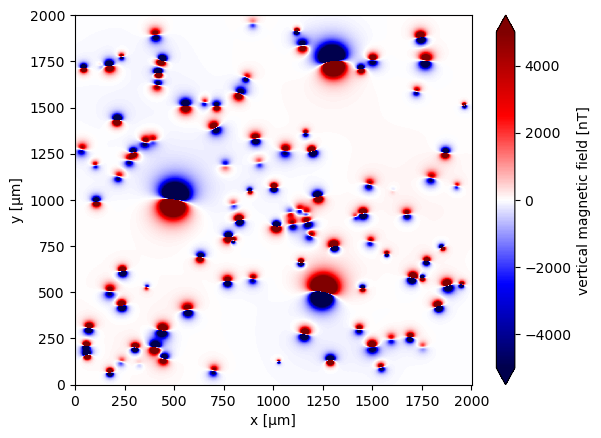

In [6]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=5000, vmin=-5000)

Add some random noise to make it more realistic.

In [7]:
noise_std_dev = 50  # nT
data.bz.values += mg.gaussian_noise(noise_std_dev, data.bz.shape, seed=42)

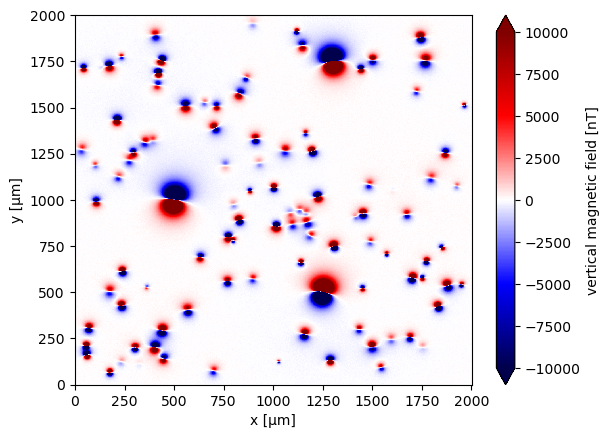

In [8]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [9]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)
data_up

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 3.699 5.177 6.767 7.257 ... -0.3299 -0.3933 -0.01999

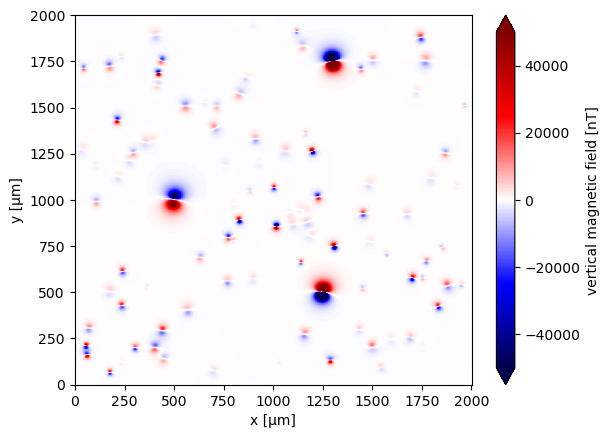

In [10]:
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=50000, vmin=-50000)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [11]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 1001, x: 1001)
Coordinates:
  * y        (y) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
  * x        (x) float64 0.0 2.0 4.0 6.0 ... 1.994e+03 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 3.699 5.177 6.767 7.257 ... -0.3299 -0.3933 -0.01999
    tga      (y, x) float64 1.514 1.423 1.934 1.808 ... 1.329 1.596 1.468 1.409
    x_deriv  (y, x) float64 0.739 0.7669 0.52 0.06259 ... -0.2063 0.07748 0.1867
    y_deriv  (y, x) float64 1.321 1.026 0.9394 1.27 ... 1.057 1.13 1.208 1.162
    z_deriv  (y, x) float64 -0.03813 -0.6186 -1.608 ... 1.108 0.8295 0.7746

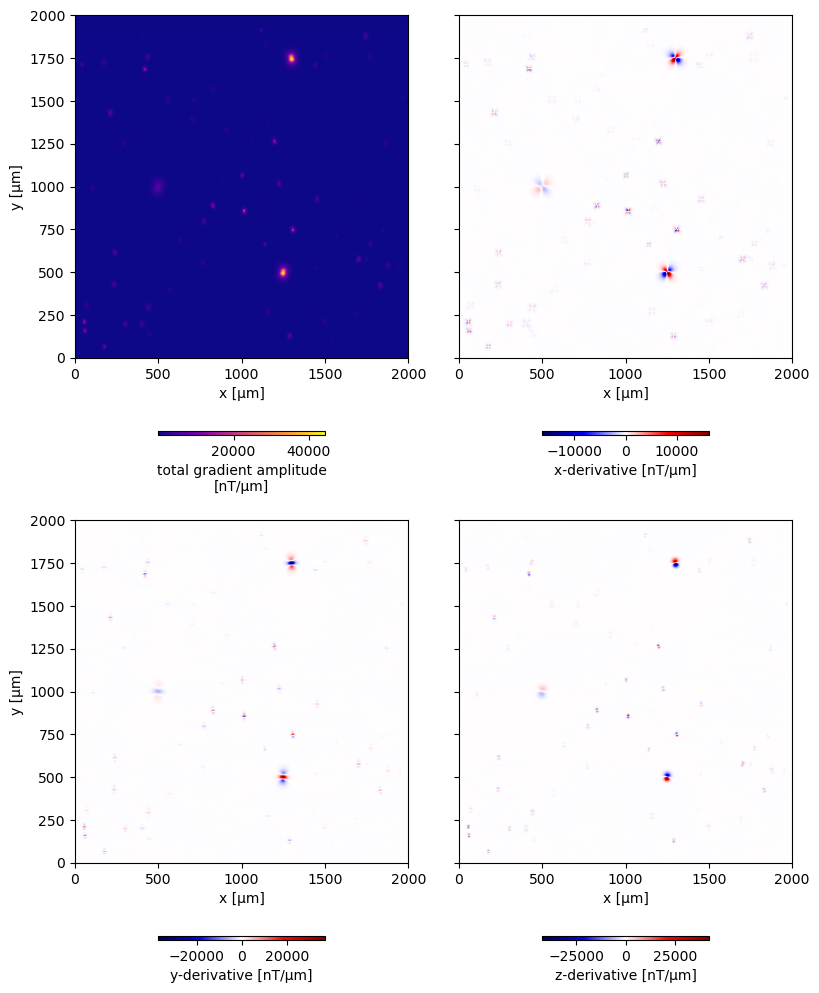

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
    else:
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [13]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)
data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

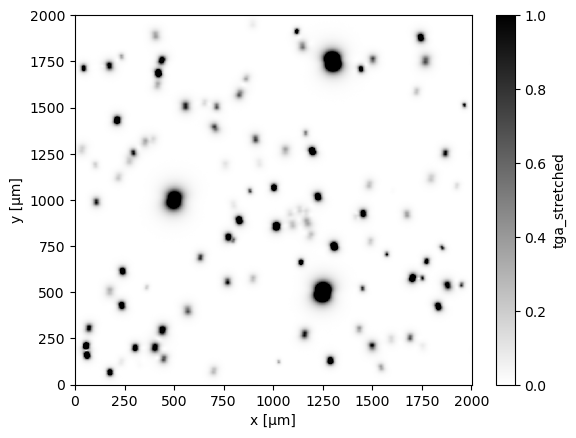

In [14]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [15]:
windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 150],
    size_increment=1.3,
    threshold=0.01,
    overlap=0.3,
    exclude_border=15
)
# windows


In [16]:
print('Sources detected: ', np.shape(windows)[0])

Sources detected:  99


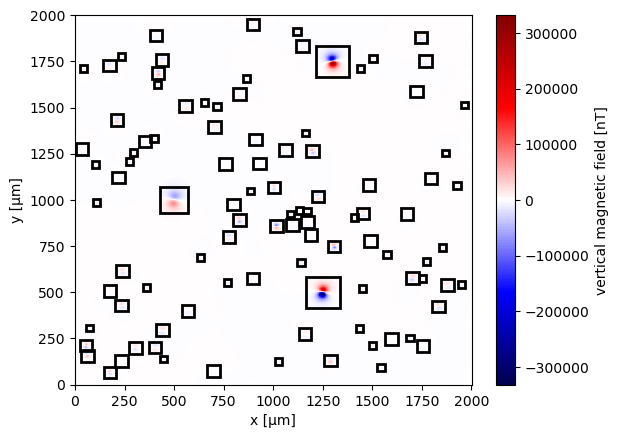

In [17]:
ax = plt.subplot(111)
data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic")
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)   

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# All sources Linear Problem

Run the enhanced Euler Deconvolution and the inversion of all sources.

In [18]:
x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
x_deriv_concat = []
y_deriv_concat = []
z_deriv_concat = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)


for window in windows:
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
    data_minus_background = anomaly.bz.values #- base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
    print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    x_deriv_concat = np.append(x_deriv_concat, anomaly.x_deriv.values)
    y_deriv_concat = np.append(y_deriv_concat, anomaly.y_deriv.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])

C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9999371898484957 and SNR: 42.221940129134616 | -14.807504116196982


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9999364035758721 and SNR: 42.24889511254335 | -14.807425035923876


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9991323518519175 and SNR: 30.626868303509028 | -2.6144902239060173


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9990959789093294 and SNR: 30.644699260514923 | -2.6147810636468827


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9991168451338859 and SNR: 30.73079105477526 | -2.609402263513231


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9992036214016089 and SNR: 32.02708476880527 | -3.6378818488860647


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9999877261497102 and SNR: 50.57395090001829 | -29.88370326912582


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9996305613730675 and SNR: 34.581093753720886 | -5.6944164100035985


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9996612977285418 and SNR: 35.14803056526036 | -6.730590211989715


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9995287889320991 and SNR: 33.40242539417201 | -4.672678478501537


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9996004059724157 and SNR: 34.49823885614882 | -5.675369117103448


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9983461463454708 and SNR: 27.815930505786007 | -2.486262496956999


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9991031922652417 and SNR: 30.545525172989105 | -5.649472588329093


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9995593415637902 and SNR: 33.66195239198178 | -6.663455266233054


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9996569811600149 and SNR: 36.66847226674665 | -8.675412158242825


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9980098159460343 and SNR: 28.200724854262667 | -1.6877343130747264


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9990860647319263 and SNR: 30.605757952832352 | -2.611643472687428


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9995195529078088 and SNR: 34.48621894487146 | -5.672760383497439


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9989534725280845 and SNR: 29.8026311945203 | -1.5711740801495653


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9983634983876041 and SNR: 27.880179984591848 | -6.79251245623544


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9996233289396864 and SNR: 35.45172487872206 | -12.008678498772733


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9987685666177261 and SNR: 29.122937425655255 | -1.5747086458207775


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9992842889191575 and SNR: 32.950419139095565 | -4.6411459036844205


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9494127492068036 and SNR: 13.018078616285768 | -6.477517594934652


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9996614815695082 and SNR: 34.71684115732944 | -4.67955677703024


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9996454470972725 and SNR: 34.63006290119512 | -4.6651305633290105


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9992463539495005 and SNR: 34.95491895605642 | -7.684236028961329


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9904234886593695 and SNR: 21.49481616446081 | -2.895646864408543


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9990902812965975 and SNR: 31.177312558479457 | -5.734459292118311


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.994909901386927 and SNR: 23.169006209693322 | -12.59210118252048


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9988041638891615 and SNR: 29.282637967212494 | -1.567035714444334


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9998540209895326 and SNR: 38.84937693787975 | -11.817724063619615


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9988365199503068 and SNR: 30.258170928901936 | -10.679105467798736


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9998718000620908 and SNR: 39.53115727785702 | -9.730328915225284


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9998496302265095 and SNR: 39.11928093711498 | -9.75772771343987


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9987064589066125 and SNR: 29.603463502326527 | -1.5760664282026786


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9997603458350224 and SNR: 39.21449322568537 | -13.792702278417499


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9866284803939613 and SNR: 19.27852383632462 | -9.800814490522344


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9995770763147156 and SNR: 34.879761829482774 | -10.667966912492137


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9992035516742872 and SNR: 32.358399789246114 | -3.6393007228971057


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9998205268644814 and SNR: 37.973107380604446 | -14.597860664502328


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9998832431836128 and SNR: 39.49323278827476 | -9.729183773153155


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9991863627031371 and SNR: 31.381485950025365 | -2.6106542866739453


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9998937565204352 and SNR: 41.75473338163242 | -14.793037401996733


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.999336479333644 and SNR: 32.28182516747097 | -3.6084285803956493


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9996145829370229 and SNR: 34.44834524340719 | -4.664211842205992


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9999146964307465 and SNR: 40.69048025086694 | -9.746924348984368


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9996341049727641 and SNR: 34.479196677908845 | -4.668836493678537


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9991039158212084 and SNR: 32.14691188552038 | -3.6419668217023773


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.999906105305332 and SNR: 41.01615905687973 | -12.776170426042476


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9998851881122457 and SNR: 39.40464606176542 | -14.850299117565141


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9999763734878394 and SNR: 46.34502084547263 | -18.803423920711356


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9995771115559696 and SNR: 34.66361459205707 | -13.673120130279665


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9996994187181752 and SNR: 35.41689421077091 | -10.628286045105762


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9997925217914405 and SNR: 37.86433522870622 | -12.72279994626303


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9997058390972516 and SNR: 35.56728748883161 | -10.73309133687237


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9999583634312085 and SNR: 44.36632250150343 | -16.796287993438096


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9999089280148779 and SNR: 41.253213789570786 | -15.97766536250556


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9996842090987575 and SNR: 37.823269885682656 | -16.84198995792702


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9994358650832648 and SNR: 34.24271454713369 | -6.676780810180528


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9997805042702197 and SNR: 39.23441193911599 | -17.86319411542921


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9988134545770794 and SNR: 31.718866460804787 | -6.738012247384402


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9989865720442649 and SNR: 33.933779196427594 | -13.803484251411483


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9998801643111525 and SNR: 39.263174397221114 | -12.655119645371501


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9998452128801444 and SNR: 38.858651999822285 | -10.690120266740166


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9489983858301719 and SNR: 13.731272344068383 | -16.391713575114366


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9999567642127077 and SNR: 44.43647116104215 | -18.843520687737573


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9997961250378871 and SNR: 37.42854937263326 | -12.664134918219665


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9937133298530727 and SNR: 26.622018515425474 | -1.5589259605592187


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.921697254473145 and SNR: 11.091345816943099 | -19.064001826627276


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9995685318244685 and SNR: 36.05390270352728 | -19.740096376229577


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9999426071175724 and SNR: 43.207497515976875 | -15.79138007638873


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9996450292420059 and SNR: 34.60608323166556 | -15.418935577567074


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9994691270474855 and SNR: 36.18632570047559 | -14.762690989007213


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9993918632971497 and SNR: 35.25986576786932 | -16.840900239740158


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9996174099540446 and SNR: 37.53942080518618 | -12.747497839578953


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9971769105935726 and SNR: 26.066063990104546 | -19.93282865346924


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9988636996012842 and SNR: 31.991288939034014 | -19.789712162462898


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9937380499297855 and SNR: 24.384781603973625 | -16.09530924869532


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9359782575134061 and SNR: 12.690979614175546 | -15.717785340255173


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9966142485420442 and SNR: 28.022102578686802 | -5.749547201887674


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9996541221558407 and SNR: 37.55552881635029 | -14.877648029142051


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.999355050969795 and SNR: 31.941647458177613 | -19.502240176054954


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9997553472300507 and SNR: 36.78774628026777 | -10.725870279044592


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9977221227251183 and SNR: 27.07466022319181 | -19.03455761212028


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9995881278731081 and SNR: 36.28941271372951 | -18.84472503652661


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9964999556071913 and SNR: 26.407100376571385 | -10.699512646194298


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9989111410922712 and SNR: 30.869182925777196 | -12.684756801046454


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9636701724063966 and SNR: 14.505547924306208 | -17.627311631047565


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9935471128249245 and SNR: 21.904295996317625 | -15.676463583255467


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9898123421530379 and SNR: 19.9420556179389 | -18.81535021061162


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9946046383652752 and SNR: 25.2614874923845 | -19.693132304177052


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9974645910141677 and SNR: 28.499774945499148 | -19.816765285746186


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.8821434275698917 and SNR: 9.298790460204767 | -16.38076574372413


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.990917355601758 and SNR: 23.729329835125146 | -16.47569942955305


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9990308269398848 and SNR: 31.777476564520054 | -18.55992346899447


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9867816284813058 and SNR: 22.172724760385144 | -15.906172953896151


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9996142277896402 and SNR: 35.16715778866051 | -18.703598739663896


C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\gelso\anaconda3\envs\doutorado\lib\site-packages\xrft\xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


R²: 0.9989299213031936 and SNR: 30.24888190549712 | -12.049210878319036


In [19]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                   'bz':bz_concat,
                   'z_deriv':z_deriv_concat,
                   'x_deriv':x_deriv_concat,
                   'y_deriv':y_deriv_concat})
df.head()

,x,y,z,bz,z_deriv,x_deriv,y_deriv
0,1166.0,416.0,10.0,-1000.533907,-46.425565,-29.707343,-18.864933
1,1168.0,416.0,10.0,-1061.022007,-50.619468,-31.324494,-21.155320
2,1170.0,416.0,10.0,-1125.831882,-52.695638,-33.256304,-23.501086
3,1172.0,416.0,10.0,-1194.047225,-55.178410,-34.761973,-25.754667
4,1174.0,416.0,10.0,-1264.879775,-59.395332,-36.500913,-27.850494


In [20]:
positions = np.array([xc_concat, yc_concat, zc_concat])
print(positions)

[[ 1.24999935e+03  1.29999933e+03  1.19800065e+03  1.30800113e+03
   1.01602392e+03  8.29013347e+02  5.00003636e+02  2.13003588e+02
   1.22604860e+03  1.28899893e+03  1.83303009e+03  4.21063732e+02
   1.70325227e+03  2.35849120e+02  1.74502897e+03  1.11889530e+03
   1.00400033e+03  2.39981948e+02  1.13999716e+03  1.45424888e+03
   4.41169745e+02  1.77022570e+02  3.04075990e+02  7.75360898e+02
   1.77401244e+03  4.39898131e+01  4.38010388e+02  6.10802720e+01
   1.44276867e+03  4.05047345e+02  5.70091972e+01  1.87989225e+03
   1.73636335e+02  7.09954847e+01  1.86901342e+03  1.96501949e+03
   1.15899667e+03  2.96119340e+02  7.69955714e+02  1.85299988e+03
   1.49995814e+03  1.07984758e+02  1.57302175e+03  5.58001687e+02
   1.75292106e+03  1.45100807e+03  6.33010997e+02  1.95103113e+03
   8.82995580e+02  9.11044113e+02  7.05889673e+02  1.76898213e+03
   1.50302041e+03  7.14818680e+02  4.48002859e+02  1.69117695e+03
   5.68966763e+02  8.30900749e+02  1.14806202e+03  1.16395357e+03
   4.07024

In [21]:
from numba import jit

@jit(nopython=True)
def kernel_uuu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along upward-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.


    """
    return 9 * (upward_p - upward_q) / distance**5 - 15 * (upward_p - upward_q)**3 / distance**7



@jit(nopython=True)
def kernel_euu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along easting-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.
    """
    return (  3 *  (easting_p - easting_q) / distance**5 
            - 15 * (easting_p - easting_q) * (upward_p - upward_q)**2 / distance**7)


@jit(nopython=True)
def kernel_nuu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along easting-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.
    """
    return (  3 *  (northing_p - northing_q) / distance**5 
            - 15 * (northing_p - northing_q) * (upward_p - upward_q)**2 / distance**7)


@jit(nopython=True)
def kernel_eeu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along easting-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.
    """
    return (  3 *  (upward_p - upward_q) / distance**5 
            - 15 * (easting_p - easting_q)**2 * (upward_p - upward_q) / distance**7)


@jit(nopython=True)
def kernel_nnu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along easting-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.
    """
    return (  3 *  (upward_p - upward_q) / distance**5 
            - 15 * (northing_p - northing_q)**2 * (upward_p - upward_q) / distance**7)



@jit(nopython=True)
def kernel_enu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along easting-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.
    """
    return ( - 15 * (easting_p - easting_q) * (northing_p - northing_q) * (upward_p - upward_q) / distance**7 )


In [25]:
import numba
import choclo
import scipy
from micromag import TESLA_TO_NANOTESLA, MICROMETER_TO_METER


from numba import jit
def all_deriv_all_dipole_moment_inversion(data, dipole_coordinates):
    
    data = data.to_xarray()
    
    n_data = len(data['z_deriv']) #table.shape[0]
    n_params = len(dipole_coordinates[0])*3
    
    Ax = np.empty((n_data, n_params))
    Ay = np.empty((n_data, n_params))
    Az = np.empty((n_data, n_params))
    
    dx = np.array(data['x_deriv']).ravel() #*-1.0e-3 # CONVERTING nT/microm to T/m
    dy = np.array(data['y_deriv']).ravel() #*-1.0e-3 # CONVERTING nT/microm to T/m
    dz = np.array(data['z_deriv']).ravel() #*-1.0e-3 # CONVERTING nT/microm to T/m
    
    d = np.hstack((dx, dy, dz))
    
    # Fill the Jacobian using a fast calculation with numba
    _dipole_jacobian_fast_x_deriv(
        data.x.values * MICROMETER_TO_METER,
        data.y.values * MICROMETER_TO_METER,
        data.z.values * MICROMETER_TO_METER,
        dipole_coordinates[0] * MICROMETER_TO_METER,
        dipole_coordinates[1] * MICROMETER_TO_METER,
        dipole_coordinates[2] * MICROMETER_TO_METER,
        Ax,
    )

    _dipole_jacobian_fast_y_deriv(
        data.x.values * MICROMETER_TO_METER,
        data.y.values * MICROMETER_TO_METER,
        data.z.values * MICROMETER_TO_METER,
        dipole_coordinates[0] * MICROMETER_TO_METER,
        dipole_coordinates[1] * MICROMETER_TO_METER,
        dipole_coordinates[2] * MICROMETER_TO_METER,
        Ay,
    )
    
    _dipole_jacobian_fast_z_deriv(
        data.x.values * MICROMETER_TO_METER,
        data.y.values * MICROMETER_TO_METER,
        data.z.values * MICROMETER_TO_METER,
        dipole_coordinates[0] * MICROMETER_TO_METER,
        dipole_coordinates[1] * MICROMETER_TO_METER,
        dipole_coordinates[2] * MICROMETER_TO_METER,
        Az,
    )
    
    A = np.vstack((Ax,Ay,Az))
    
    
    print(np.shape(A))
    print(np.shape(d))
    
    hessian = A.T @ A
    neg_gradient = A.T @ d
    dipole_moment = scipy.linalg.solve(hessian, neg_gradient, assume_a="pos")
    residuals = d - A @ dipole_moment
    
    dipole_moment = np.reshape(dipole_moment, (int(n_params/3), 3) )
    return dipole_moment * 1.0e-3


@numba.jit(nopython=True, parallel=True)
def _dipole_jacobian_fast_x_deriv(e, n, u, de, dn, du, jacobian):
    """
    This is the bit that runs the fast for-loops
    """
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    for j in numba.prange(len(de)):
        for i in numba.prange(len(e)):
            # Calculating the distance only once saves a lot of computation time
            distance = choclo.utils.distance_cartesian(
                e[i],
                n[i],
                u[i],
                de[j],
                dn[j],
                du[j],
            )
            # These are the second derivatives of 1/r
            jacobian[i, j*3] = constant*kernel_eeu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            jacobian[i, j*3+1] = constant*kernel_enu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance=distance,
            )
            jacobian[i, j*3+2] = constant*kernel_euu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            
@numba.jit(nopython=True, parallel=True)
def _dipole_jacobian_fast_y_deriv(e, n, u, de, dn, du, jacobian):
    """
    This is the bit that runs the fast for-loops
    """
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    for j in numba.prange(len(de)):
        for i in numba.prange(len(e)):
            # Calculating the distance only once saves a lot of computation time
            distance = choclo.utils.distance_cartesian(
                e[i],
                n[i],
                u[i],
                de[j],
                dn[j],
                du[j],
            )
            # These are the second derivatives of 1/r
            jacobian[i, j*3] = constant*kernel_enu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            jacobian[i, j*3+1] = constant*kernel_nnu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance=distance,
            )
            jacobian[i, j*3+2] = constant*kernel_nuu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            
@numba.jit(nopython=True, parallel=True)
def _dipole_jacobian_fast_z_deriv(e, n, u, de, dn, du, jacobian):
    """
    This is the bit that runs the fast for-loops
    """
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    for j in numba.prange(len(de)):
        for i in numba.prange(len(e)):
            # Calculating the distance only once saves a lot of computation time
            distance = choclo.utils.distance_cartesian(
                e[i],
                n[i],
                u[i],
                de[j],
                dn[j],
                du[j],
            )
            # These are the second derivatives of 1/r
            jacobian[i, j*3] = constant*kernel_euu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            jacobian[i, j*3+1] = constant*kernel_nuu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance=distance,
            )
            jacobian[i, j*3+2] = constant*kernel_uuu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            

Calculate dipole moments using all interfering sources.

In [26]:
estimated_dipole_moments = all_deriv_all_dipole_moment_inversion(df, positions)

(263241, 297)
(263241,)


Calculate predicted data

In [27]:
predicted_data = mg.dipole_bz([coordinates[0], coordinates[1], data_up.z], positions, estimated_dipole_moments)
residuo = data.bz.values - predicted_data

data_up = data_up.assign(predicted_data=(['y','x'],predicted_data))
data_up.predicted_data.attrs = {"long_name": "predicted-data", "units": "nT"}

error = data_up.bz.values - data_up.predicted_data.values

data_up = data_up.assign(error=(['y','x'],error))
data_up.error.attrs = {"long_name": "residual-data", "units": "nT"}

data_up

<xarray.Dataset>
Dimensions:         (y: 1001, x: 1001)
Coordinates:
  * y               (y) float64 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * x               (x) float64 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z               (y, x) float64 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz              (y, x) float64 3.699 5.177 6.767 ... -0.3933 -0.01999
    tga             (y, x) float64 1.514 1.423 1.934 1.808 ... 1.596 1.468 1.409
    x_deriv         (y, x) float64 0.739 0.7669 0.52 ... -0.2063 0.07748 0.1867
    y_deriv         (y, x) float64 1.321 1.026 0.9394 1.27 ... 1.13 1.208 1.162
    z_deriv         (y, x) float64 -0.03813 -0.6186 -1.608 ... 0.8295 0.7746
    tga_stretched   (y, x) float64 0.0006501 0.0005952 ... 0.0006223 0.000587
    predicted_data  (y, x) float64 -4.361 -4.399 -4.438 ... 0.3266 0.2928 0.2601
    error           (y, x) float64 8.06 9.576 11.21 ... -0.6565 -0.6861 -0.2801

Calculate r2 and SNR for all sources.

In [28]:
calculated_r2  = []
calculated_SNR  = []
for window in windows:
    local_data = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
        
    residuals_sum_sq = np.sum((local_data.error.values)**2)
    
    r2  = 1 - residuals_sum_sq / np.linalg.norm( np.array(local_data.bz.values) - float(local_data.bz.mean()) ) ** 2
    SNR = 10 * np.log10(np.var(local_data.bz.values, ddof=1) / np.var(local_data.error.values, ddof=1))
    
    calculated_r2 = np.append(calculated_r2, r2)
    calculated_SNR = np.append(calculated_SNR, SNR)

Compare the Euler Deconvolution estimated position on each window to the source true positions.

In [29]:
tree = sp.spatial.KDTree(np.transpose(dipole_coordinates))
closest = tree.query(np.transpose(positions))[1]
z_difference = positions[2] - np.array(dipole_coordinates[2])[closest]
z_difference

array([ 0.19249588,  0.19257496,  0.38550978,  0.38521894,  0.39059774,
        0.36211815,  0.11629673,  0.30558359,  0.26940979,  0.32732152,
        0.32463088,  0.5137375 ,  0.35052741,  0.33654473,  0.32458784,
        0.31226569,  0.38835653,  0.32723962,  0.42882592,  0.20748754,
       -0.0086785 ,  0.42529135,  0.3588541 ,  0.52248241,  0.32044322,
        0.33486944,  0.31576397,  0.10435314,  0.26554071,  0.40789882,
        0.43296429,  0.18227594,  0.32089453,  0.26967108,  0.24227229,
        0.42393357,  0.20729772, -0.80081449,  0.33203309,  0.36069928,
        0.40213934,  0.27081623,  0.38934571,  0.2069626 ,  0.39157142,
        0.33578816,  0.25307565,  0.33116351,  0.35803318,  0.22382957,
        0.14970088,  0.19657608,  0.32687987,  0.37171395,  0.27720005,
        0.26690866,  0.20371201,  0.02233464,  0.15801004,  0.32321919,
        0.13680588,  0.26198775,  0.19651575,  0.34488035,  0.30987973,
        3.60828642,  0.15647931,  0.33586508,  0.44107404, -2.06

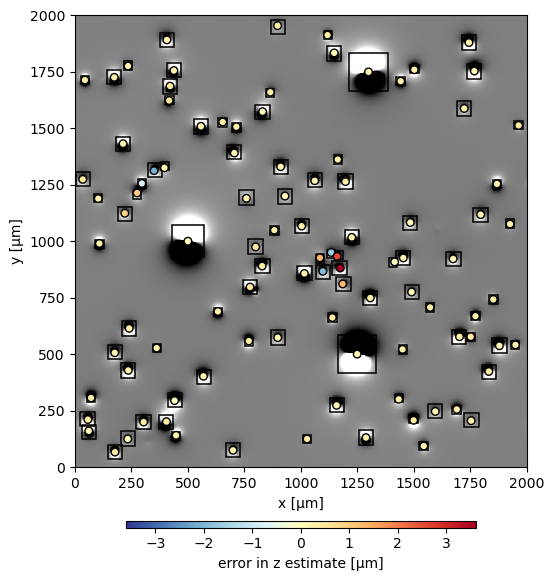

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.09, shrink=0.5)

data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-3000, vmax=3000, add_colorbar=False)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=1.1,
    )
    ax.add_patch(rect)
scale = vd.maxabs(z_difference)
tmp = ax.scatter(*positions[:2], c=z_difference, cmap="RdYlBu_r", vmin=-scale, vmax=scale, s=30, edgecolor='k')
fig.colorbar(tmp, **cbar_kwargs, label="error in z estimate [µm]")

ax.set_aspect("equal")
plt.tight_layout(w_pad=0, pad=0)

In [31]:
direction_misfit = []
magnetic_moment_misfit = []

for estimated, true in zip(estimated_dipole_moments, dipole_moments[closest] ):
    einc, edec, eamp = mg.vector_to_angles(estimated)
    inc, dec, amp = mg.vector_to_angles(true)

    
    # Calculate misfits
    dir_misfit = float(np.degrees(mplstereonet.angular_distance(
                            mplstereonet.line(inc, dec), mplstereonet.line(einc, edec), bidirectional=False))) # degrees
    magm_mom_misfit = abs(float((amp-eamp)/amp)*100) # %
    
    direction_misfit.append(dir_misfit)
    magnetic_moment_misfit.append(magm_mom_misfit)
    
    # print(f"Inclination: {inc} | {einc} ± {sigma_inc:.3f}")
    # print(f"Declination: {dec} | {edec} ± {sigma_dec:.3f}")
    # print(f"Amplitude  : {amp:e} | {eamp:e} ± {sigma_amp:.1e}")
    # print(f"R²   : {r2:.5f} ")
    # print(f"SNR  : {SNR:.5f} ")
    # print(f"Direction Misfit  : {dir_misfit:.2f}° ")
    # print(f"Magnetic Moment Misfit  : {magm_mom_misfit:.2f} %")
    # print()

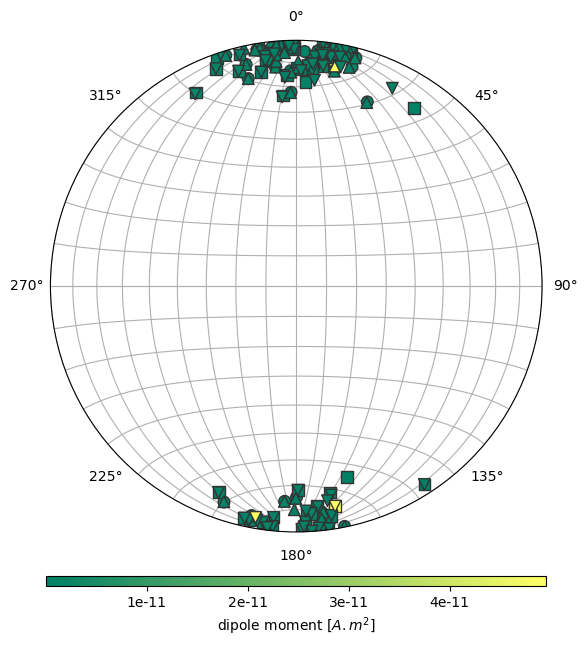

In [32]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments)
true = mg.vector_to_angles(dipole_moments)
scatter_args = dict(
    vmin=np.min([np.min(estimated[2]), np.min(true[2])]),
    vmax=np.min([np.max(estimated[2]), np.max(true[2])]),
    cmap="summer",
    edgecolors="#333333",
    linewidths=1,
    s=70,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=estimated[2][pos_inc],
    marker="o",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=estimated[2][~pos_inc],
    marker="s",
    **scatter_args,
)
pos_inc = true[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(true[0][pos_inc], true[1][pos_inc]),
    c=true[2][pos_inc],
    marker="^",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-true[0][~pos_inc], true[1][~pos_inc]),
    c=true[2][~pos_inc],
    marker="v",
    **scatter_args,
)
fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.0e",
)
plt.show()

# Article figure

Make nice figures out of these results for the paper. These are more elaborate figures that are designed for the printed page in particular.

In [33]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

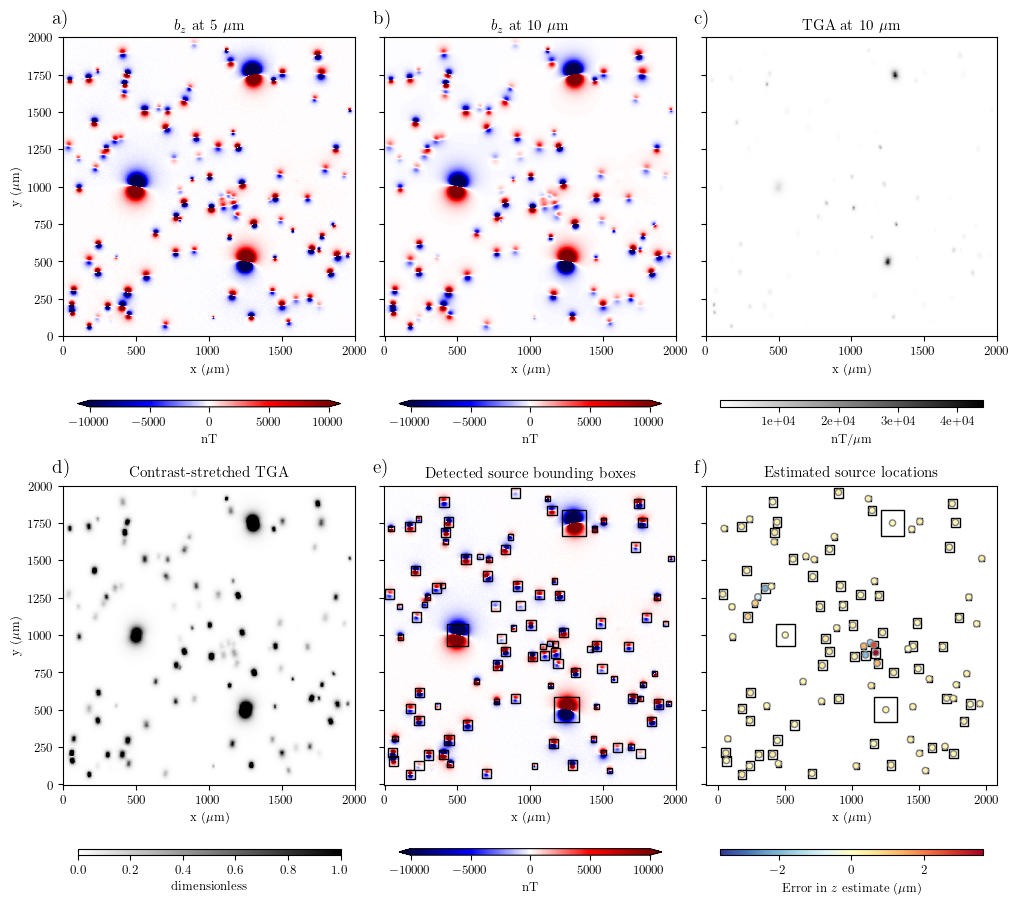

In [34]:
vmax=+10000
vmin=-10000
with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 3, figsize=(10, 9), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
    
    ax = axes[0]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[1]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    
    ax = axes[2]   
    ax.set_aspect("auto")
    ax.set_title(f"TGA at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data_up.tga.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT/$\mu$m", **cbar_kwargs, format="%.0e")
    
    ax = axes[3]  
    ax.set_aspect("auto")
    ax.set_title(f"Contrast-stretched TGA")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="gray_r", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs)
    
    ax = axes[4]  
    ax.set_aspect("auto")
    ax.set_title(f"Detected source bounding boxes")
    ax.set_xlabel("x ($\mu$m)")
    tmp = data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')    
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)   

    ax = axes[5]  
    ax.set_aspect("auto")
    ax.set_title(f"Estimated source locations")
    ax.set_xlabel("x ($\mu$m)")
    scale = 100
#     tmp = data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r",  add_colorbar=False, add_labels=False)
    for window in windows:
        rect = matplotlib.patches.Rectangle(
            xy=[window[0], window[2]],
            width=window[1] - window[0],
            height=window[3] - window[2],
            edgecolor="k",
            fill=False,
            linewidth=1,
        )
        ax.add_patch(rect)
    scale = vd.maxabs(z_difference)
    tmp = ax.scatter(*positions[:2], c=z_difference, s=20, cmap="RdYlBu_r", vmin=-scale, vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="Error in $z$ estimate ($\mu$m)", **cbar_kwargs)    
    
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=14)

    plt.tight_layout(pad=0, h_pad=0, w_pad=0.6)
    
#     fig.savefig(fig_dir / "complex-synthetic-data.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()

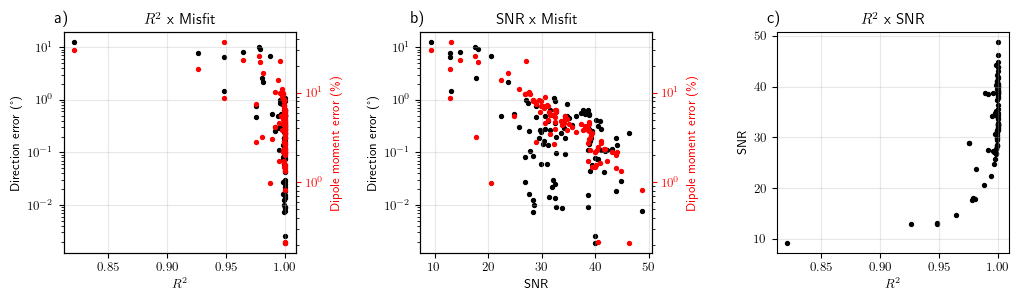

In [35]:
with plt.rc_context(mpl_rc):
    size=8
    fig, axes = plt.subplots(1,3, figsize=(10, 2.8))    

    axes = axes.ravel()
    ax = axes[0]
    ax.scatter(calculated_r2, direction_misfit, color='k', s=size)
    ax.set_ylabel('Direction error (°)')
    ax.set_xlabel('$R^2$')
    ax.set_yscale('log')
    ax = ax.twinx()
    ax.scatter(calculated_r2, magnetic_moment_misfit,  color='r', s=size)
    
    ax.set_ylabel('Dipole moment error (\%)', color='r')
    ax.tick_params(axis='y', colors='red')
    ax.set_yscale('log')

    ax = axes[1]
    ax.scatter(calculated_SNR, direction_misfit, color='k', s=size, label='direction (°)')
    ax.set_ylabel('Direction error (°)')
    ax.set_xlabel('SNR')
    ax.set_yscale('log')
    ax = ax.twinx()
    ax.scatter(calculated_SNR, magnetic_moment_misfit,  color='r', s=size)
    
    ax.set_xlabel('SNR')
    ax.set_ylabel('Dipole moment error (\%)', color='r')
    ax.tick_params(axis='y', colors='red')
    ax.set_yscale('log')

    ax = axes[2]
    ax.scatter(calculated_r2, calculated_SNR, color='k', s=size)
    ax.set_xlabel('$R^2$')
    ax.set_ylabel('SNR')

    titles = [r'$R^2$ x Misfit', r'SNR x Misfit', r'$R^2$ x SNR']
    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=12)
        ax.set_aspect("auto")
        ax.grid(alpha=0.3, which='major')
        ax.set_title(title)




    plt.tight_layout(pad=0, h_pad=0, w_pad=2)
    
#     fig.savefig(fig_dir / "complex-synthetic-fitting-test.png", dpi=300, facecolor='w', bbox_inches='tight')

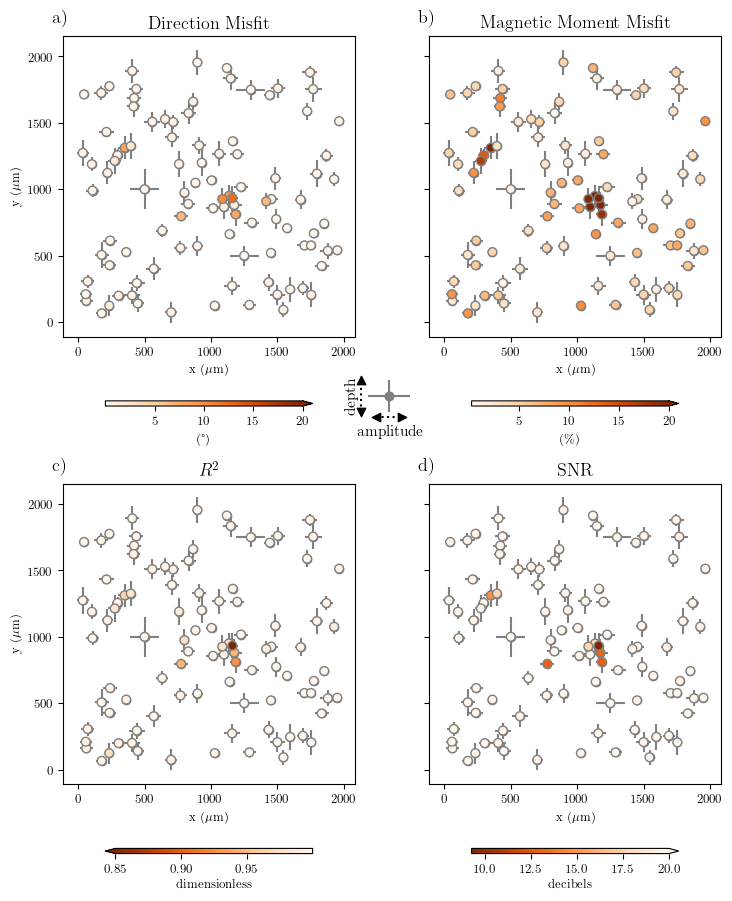

In [36]:
inc, dec, amp = mg.vector_to_angles(dipole_moments)
einc, edec, eamp = mg.vector_to_angles(estimated_dipole_moments)

scale_depth = (np.array(dipole_coordinates[2])[closest]/np.array(dipole_coordinates[2])[closest].max())*10
scale_amp= abs(np.log(np.array(amp)[closest])-np.log(np.array(amp)[closest]).min())*15

vmax=+10000
vmin=-10000

with plt.rc_context(mpl_rc):

    fig, axes = plt.subplots(2, 2, figsize=(8, 9), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.5)
    
    ax = axes[0]
    ax.set_aspect("equal")
    ax.set_title("Direction Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    

    scale = 20
    tmp = ax.scatter(*positions[:2], c=direction_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="(°)", **cbar_kwargs, extend='max') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    ax = axes[1]
    ax.set_aspect("equal")
    ax.set_title("Magnetic Moment Misfit", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")

    scale = 20
    tmp = ax.scatter(*positions[:2], c=magnetic_moment_misfit, s=40, cmap="Oranges", vmax=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label=f"(\%)", **cbar_kwargs, extend='max') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    ax = axes[2]   
    ax.set_aspect("equal")
    ax.set_title(f"$R^2$", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")

    scale = 0.85
    tmp = ax.scatter(*positions[:2], c=calculated_r2, s=40, cmap="Oranges_r", vmin=scale, edgecolor='gray')
    fig.colorbar(tmp, ax=ax, label="dimensionless", **cbar_kwargs, extend='min') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    ax = axes[3]  
    ax.set_aspect("equal")
    ax.set_title(f"SNR", fontsize=13)
    ax.set_xlabel("x ($\mu$m)")
    
    scale = 20
    tmp = ax.scatter(*positions[:2], c=calculated_SNR, s=40, cmap="Oranges_r", edgecolor='gray', vmax=scale)
    fig.colorbar(tmp, ax=ax, label="decibels", **cbar_kwargs, extend='max') 
    ax.errorbar(*positions[:2], xerr=scale_amp, yerr=scale_depth, fmt='o', zorder=0, color='gray')
    
    for ax, letter in zip(axes, "a b c d".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_aspect("equal")
#         ax.scatter(*dipole_coordinates[:2], color='k', marker='x', zorder=-1)
        
    plt.tight_layout(pad=0, h_pad=0, w_pad=0.5)
    
    
    
    left, bottom, width, height = [0.45, 0.52, 0.09, 0.09]
    ax5 = fig.add_axes([left, bottom, width, height])
    ax5.errorbar(0.5, 0.5, 0.5, 0.5, 
                 fmt='o', zorder=0, color='gray')
    ax5.scatter(0.5, 0.5, color='gray', edgecolor='gray', zorder=5)
    ax5.set_ylim(-1.0, 1.5)
    ax5.set_xlim(-0.6, 1.1)

    ax5.vlines(-0.15, -0.0, 1.0, linestyle=':', color='k')
    ax5.hlines(-0.15, 0.2, 0.8, linestyle=':', color='k')
    ax5.scatter(-0.15, -0.0, marker='v', color='k')
    ax5.scatter(-0.15, 1.0, marker='^', color='k')

    ax5.scatter(0.2,-0.15, marker='<', color='k')
    ax5.scatter(0.8,-0.15, marker='>', color='k')

    ax5.text(-0.25, -0.7, 'amplitude', color='k', fontsize=11)
    ax5.text(-0.55, 0.01, 'depth', color='k', rotation='vertical', fontsize=11)

    ax5.set_title('', loc='left')
    # Eliminate upper and right axes
    ax5.spines['right'].set_color('none')
    ax5.spines['top'].set_color('none')
    ax5.spines['bottom'].set_color('none')
    ax5.spines['left'].set_color('none')
    ax5.xaxis.set_ticks([])
    ax5.yaxis.set_ticks([])
    
#     fig.savefig(fig_dir / "complex-synthetic-comparison.png", dpi=300, facecolor='w', bbox_inches='tight')
    
    plt.show()


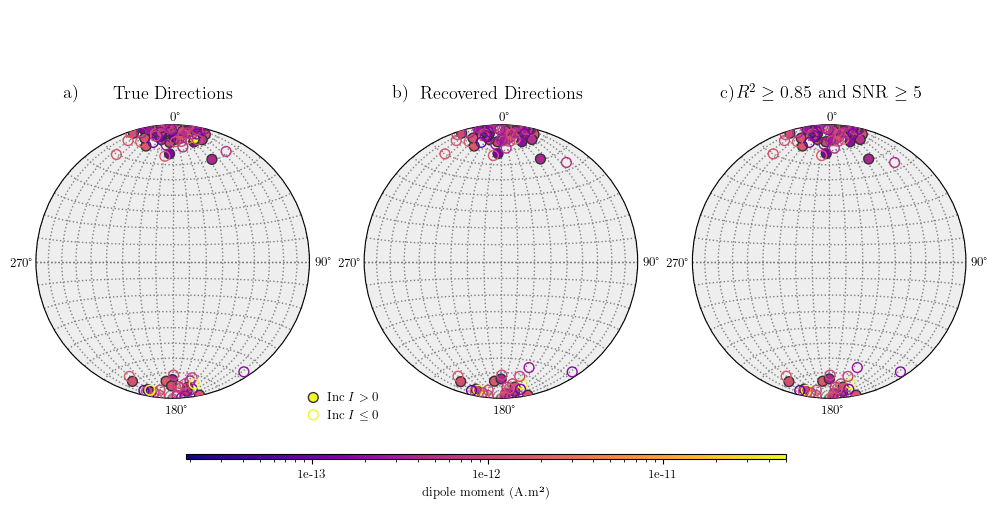

In [37]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(12, 5))
    axes = []
    
    ax = fig.add_subplot(1, 3, 1, projection='stereonet')
    axes.append(ax)    
    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    true = mg.vector_to_angles(dipole_moments)[2]
    vmin = np.min((np.min(estimated), np.min(true)))
    vmax = np.max((np.max(estimated), np.max(true)))
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(dipole_moments, marker="o", zorder=2000, **kwargs)

    
    ax = fig.add_subplot(1, 3, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(-0.25, -0.1), frameon=False, handletextpad=0.1)
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.1, 0.5, 0.01]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )
    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T
    
    ax = fig.add_subplot(1, 3, 3, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs)

    titles = ('True Directions', 'Recovered Directions', '$R^2 \geq 0.85$ and SNR $\geq 5$')

    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
        ax.set_azimuth_ticks([])
        ax.grid(linestyle=':', color='gray')
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2)

    plt.show()


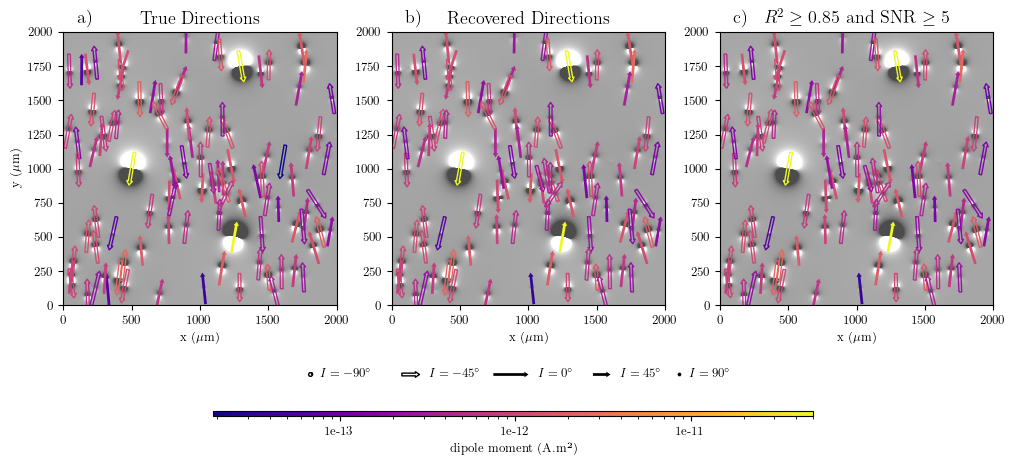

In [38]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(12, 5))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    true = mg.vector_to_angles(dipole_moments)[2]
    vmin = np.min( (np.min(estimated), np.min(true)))
    vmax = np.max( (np.max(estimated), np.max(true)))
    cmap = "plasma"

    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
    ax = fig.add_subplot(1, 3, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 2000
#     ax.pcolormesh(data_up.bz, cmap="gray", vmin=-scale, vmax=scale)
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
    
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        dipole_coordinates, dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=700, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    ax.set_aspect("equal")
    
    
    ax = fig.add_subplot(1, 3, 2)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 2000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
#     ax.pcolormesh(data_up.bz, cmap="gray", vmin=-scale, vmax=scale)
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=700, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_xlabel("x ($\mu$m)")
#     ax.set_ylabel("y ($\mu$m)")
    ax.set_aspect("equal")

    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.3, -0.25, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k')
    ax.quiverkey(negquiver, 0.1, -0.25, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k')
    ax.quiverkey(posquiver, 0.5, -0.25, 90, label="$I =   0^\circ$", labelpos="E", color='k')
    ax.quiverkey(posquiver, 0.8, -0.25, 45, label="$I =  45^\circ$", labelpos="E", color='k')
    ax.quiverkey(posquiver, 1.05, -0.25, 0., label="$I =  90^\circ$", labelpos="E", color='k')
    
    
    
    
    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    
    ax = fig.add_subplot(1, 3, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 2000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
#     ax.pcolormesh(data_up.bz, cmap="gray", vmin=-scale, vmax=scale)
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=700, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_xlabel("x ($\mu$m)")
#     ax.set_ylabel("y ($\mu$m)")
    ax.set_aspect("equal")
    
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.0, 0.5, 0.01]), 
        format="%.0e",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )
    

    titles = ('True Directions', 'Recovered Directions', '$R^2 \geq 0.85$ and SNR $\geq 5$')

    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=13)
        ax.set_title(title, fontsize=13)
    fig.subplots_adjust(wspace=0.2)
    
    plt.show()


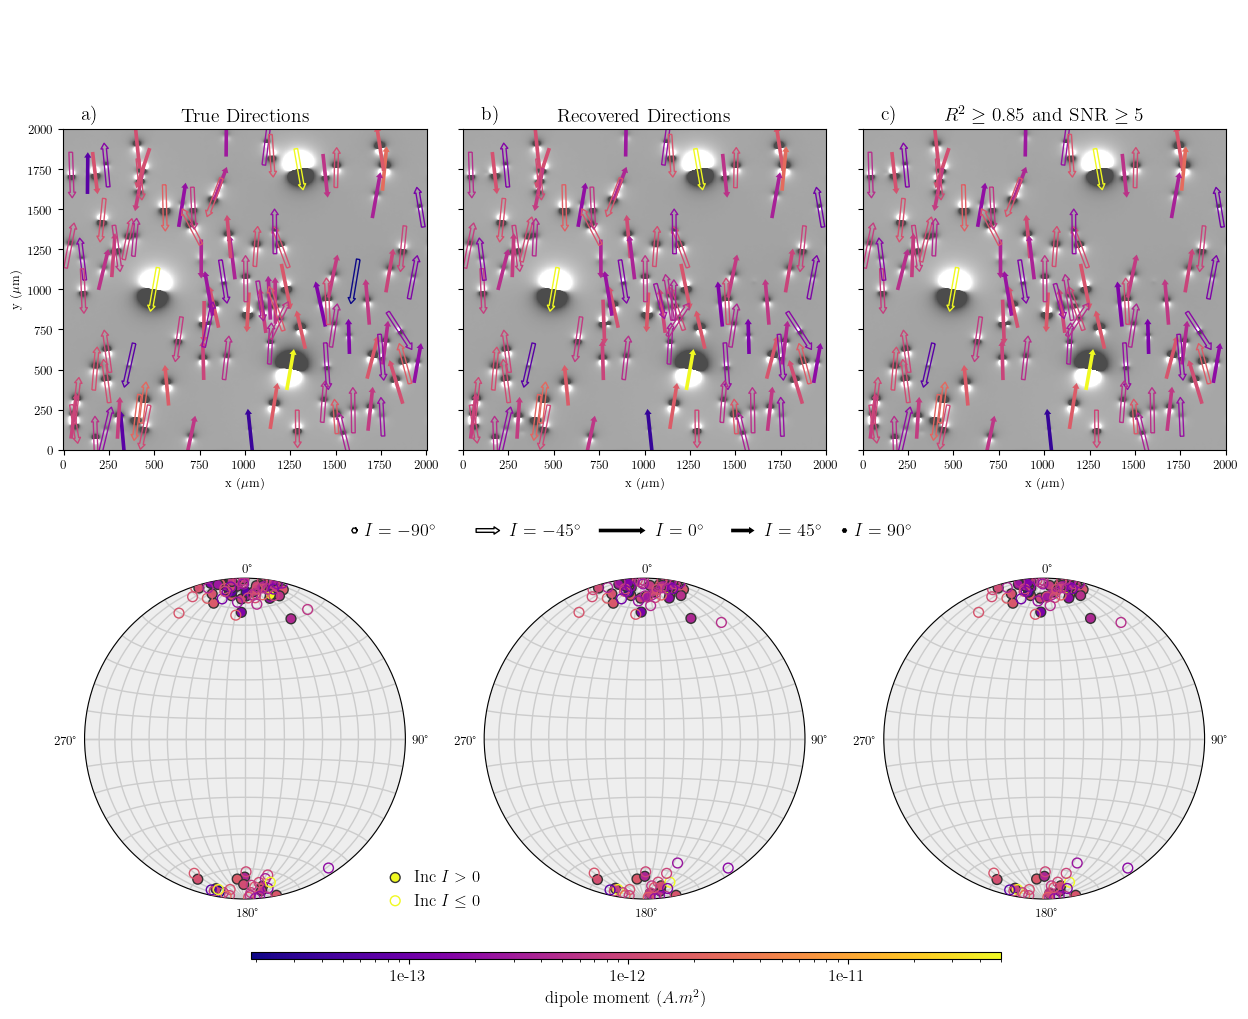

In [39]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(15, 10))
    
    axes = []

    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    true = mg.vector_to_angles(dipole_moments)[2]
    vmin = np.min( (np.min(estimated), np.min(true)))
    vmax = np.max( (np.max(estimated), np.max(true)))
    cmap = "plasma"

    cmap_norm = matplotlib.colors.LogNorm #Normalize
    
#################################################################################################
#                                             Maps
#################################################################################################
    ax = fig.add_subplot(2, 3, 1)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 2000
 
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
    
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        dipole_coordinates, dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=700, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")

    
    
    ax = fig.add_subplot(2, 3, 2)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 2000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        positions, estimated_dipole_moments, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=700, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_xlabel("x ($\mu$m)")
    plt.yticks(color='w')
    
    # Inc values seem to be reversed because the function uses 90 - inc to plot instead of inc.
    ax.quiverkey(negquiver,-0.3, -0.25, 0., label="$I = -90^\circ$", labelpos="E", edgecolor='k', 
                 fontproperties={'size': 'x-large', 'weight': 'bold'})
    ax.quiverkey(negquiver, 0.1, -0.25, 45, label="$I = -45^\circ$", labelpos="E", edgecolor='k',
                 fontproperties={'size': 'x-large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.5, -0.25, 90, label="$I =   0^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'x-large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 0.8, -0.25, 45, label="$I =  45^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'x-large', 'weight': 'bold'})
    ax.quiverkey(posquiver, 1.05, -0.25, 0., label="$I =  90^\circ$", labelpos="E", color='k',
                 fontproperties={'size': 'x-large', 'weight': 'bold'})
    

    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter] 
                                     ]).T
    
    filter_positions = np.array( [np.array(positions)[0][pos_filter], 
                                  np.array(positions)[1][pos_filter], 
                                  np.array(positions)[2][pos_filter]
                                 ])
    
    ax = fig.add_subplot(2, 3, 3)
    axes.append(ax)
    ax.set_title("Estimated dipole moments over the synthetic $b_z$")
    scale = 2000
    data_up.bz.plot.pcolormesh(ax=ax, cmap="gray_r", vmin=-scale, vmax=scale, 
                                   add_colorbar=False, add_labels=False, alpha=0.7, zorder=-1)
 
    tmp, posquiver, negquiver = mg.plot_dipole_moment(
        filter_positions, filter_estimated_d_m, 
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap, cmap_norm=cmap_norm, 
        scale=700, width=0.01, linewidth=1, add_key=False, add_colorbar=False,
    )
    ax.set_xlabel("x ($\mu$m)")
    plt.yticks(color='w')
    
    clb = fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.0075]), 
        format="%.0g",
#         label="dipole moment (A.m²)",
        orientation="horizontal"
    )
    
    clb.set_label(label="dipole moment ($A.m^2$)", fontsize=12)
    
    clb.ax.tick_params(labelsize=12)
    
#################################################################################################
#                                           Stereograms
#################################################################################################

    ax = fig.add_subplot(2, 3, 4, projection='stereonet')
    axes.append(ax)    
    estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
    true = mg.vector_to_angles(dipole_moments)[2]
    vmin = np.min((np.min(estimated), np.min(true)))
    vmax = np.max((np.max(estimated), np.max(true)))
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize
    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(dipole_moments, marker="o", zorder=2000, **kwargs, add_ticks=True)

    
    ax = fig.add_subplot(2, 3, 5, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs, add_ticks=True)
    
    ax.legend(loc=(-0.35, -0.05), frameon=False, handletextpad=0.1, prop = {'size' : 12})

    
    pos_filter= ( (np.array(calculated_r2) > 0.85) & (np.array(calculated_SNR) > 5))

    filter_estimated_d_m = np.array( [np.array(estimated_dipole_moments)[:,0][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,1][pos_filter], 
                                      np.array(estimated_dipole_moments)[:,2][pos_filter]
                                     ]).T
    
    ax = fig.add_subplot(2, 3, 6, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(filter_estimated_d_m, marker="o", zorder=1000, **kwargs, add_ticks=True)


    
    titles = ('True Directions', 'Recovered Directions', '$R^2 \geq 0.85$ and SNR $\geq 5$')

    for ax, letter, title in zip(axes, "a b c".split(), titles):
        ax.text(0.05, 1.031, f"{letter})", transform=ax.transAxes, fontsize=14)
        ax.set_title(title, fontsize=14)
        ax.set_aspect("auto")
    
        
    fig.subplots_adjust(wspace=0.1, hspace=0.4)
#     fig.savefig(fig_dir / "complex-synthetic-stereograms.png", dpi=300, facecolor='w', bbox_inches='tight')
    plt.show()

### Show the observed and predicted data

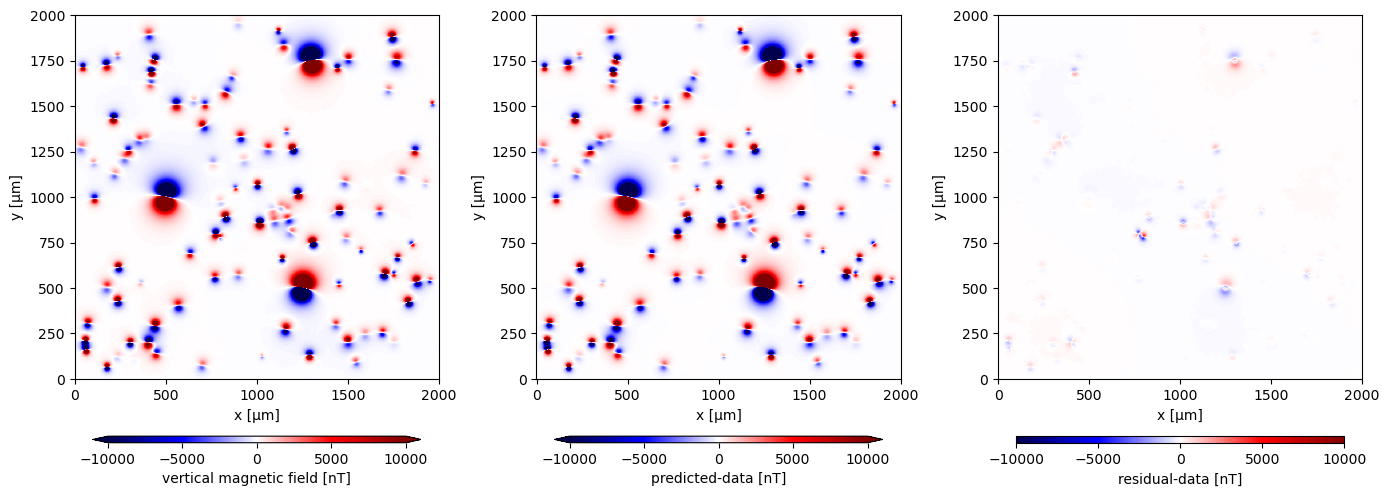

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(14, 6))
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.1, shrink=0.9)
for field, ax in zip(["bz", "predicted_data", "error"], axes.ravel()):
    vmax = +10000
    vmin = -10000
    data_up[field].plot.pcolormesh(ax=ax, cmap="seismic", cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("equal")
plt.tight_layout()

### Show each window results
We displayed only the first 15 windows

Individual source:   R2 = 0.9998964808864216 and SNR = 40.008647483955826


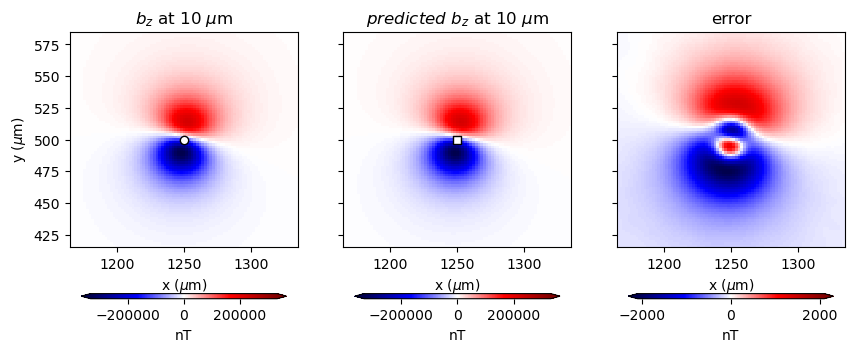

Individual source:   R2 = 0.9998963628136067 and SNR = 40.05696503229353


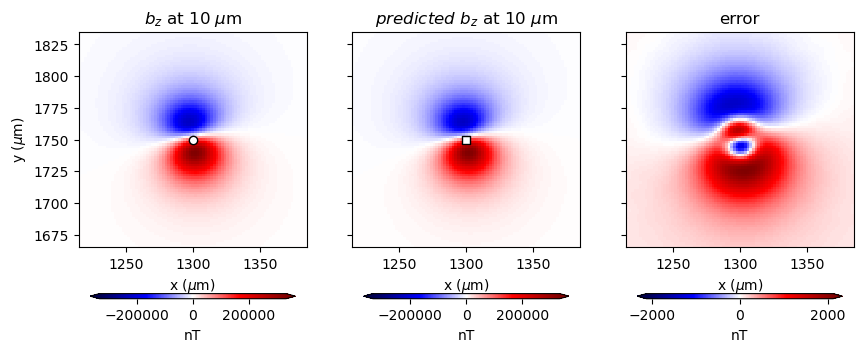

Individual source:   R2 = 0.9985557663666932 and SNR = 28.449908926018466


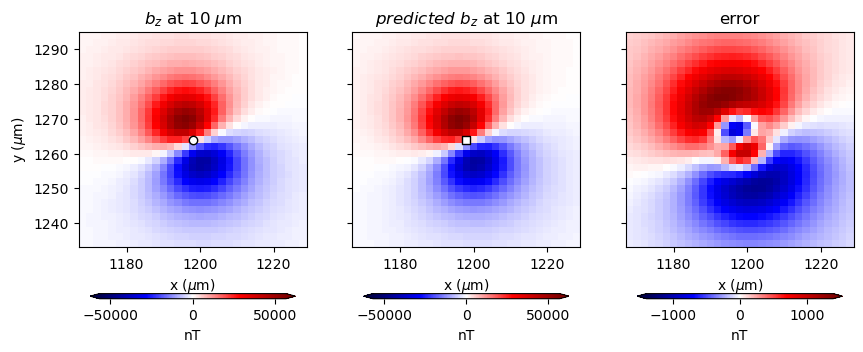

Individual source:   R2 = 0.9985362716180545 and SNR = 28.531613911537363


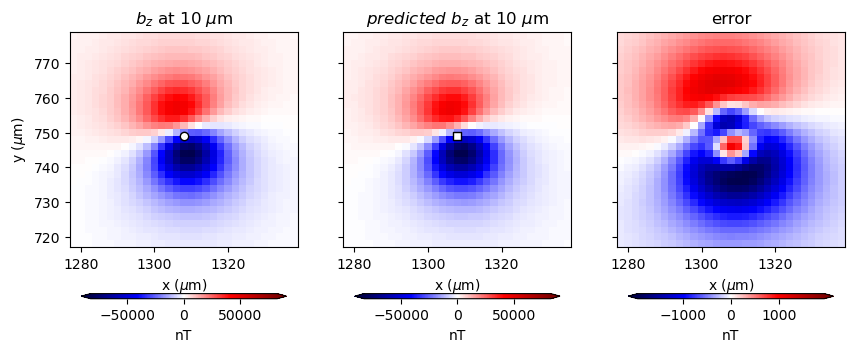

Individual source:   R2 = 0.9984715168443501 and SNR = 28.36711022829433


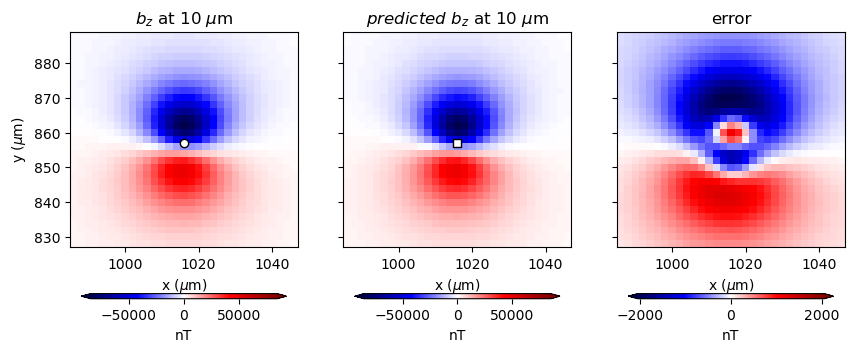

Individual source:   R2 = 0.9988744765375246 and SNR = 29.870591763195602


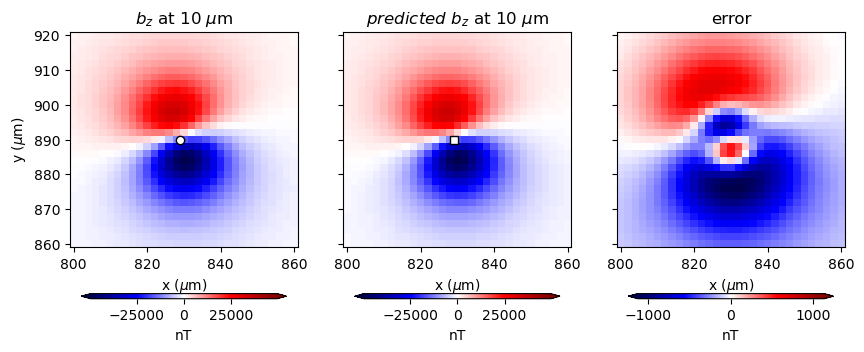

Individual source:   R2 = 0.9999822447038088 and SNR = 48.76128166464596


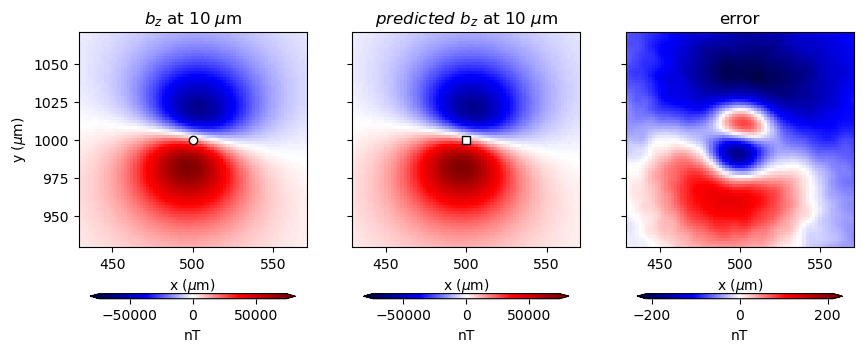

Individual source:   R2 = 0.9994016285727132 and SNR = 32.451720478158485


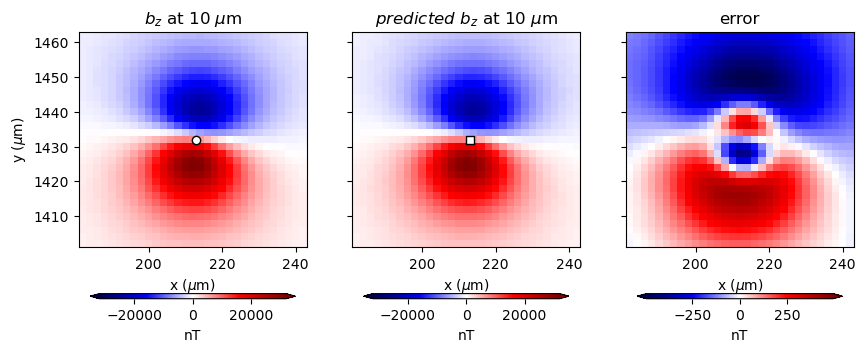

Individual source:   R2 = 0.9995761804831425 and SNR = 33.780667013211804


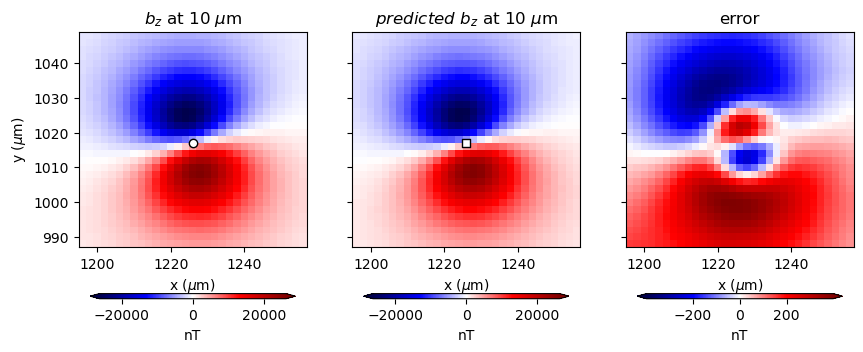

Individual source:   R2 = 0.9992734326339089 and SNR = 31.393554287084267


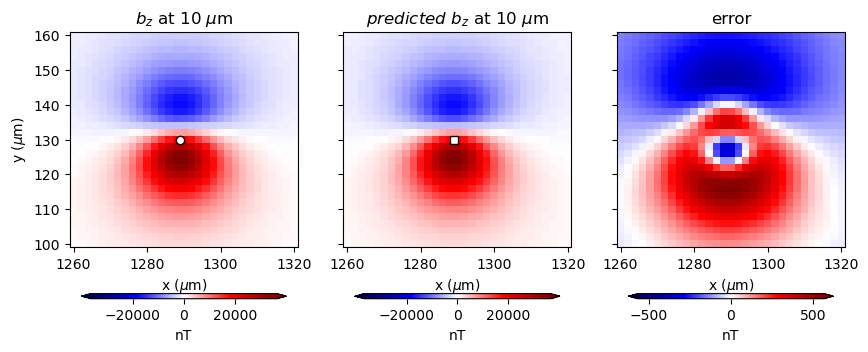

Individual source:   R2 = 0.9993560258440195 and SNR = 31.92209033772595


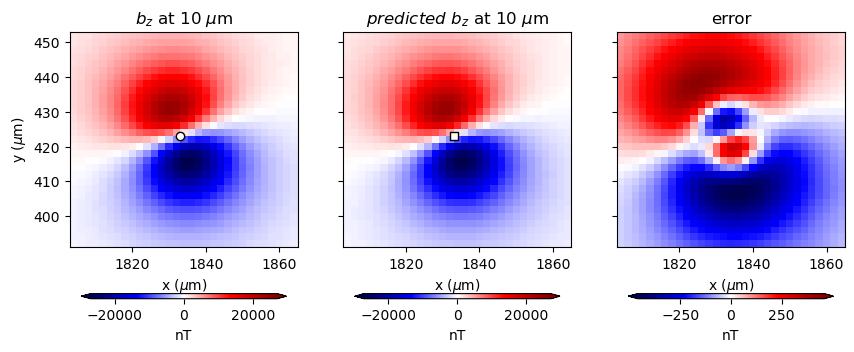

Individual source:   R2 = 0.9973641776520777 and SNR = 25.79138133265647


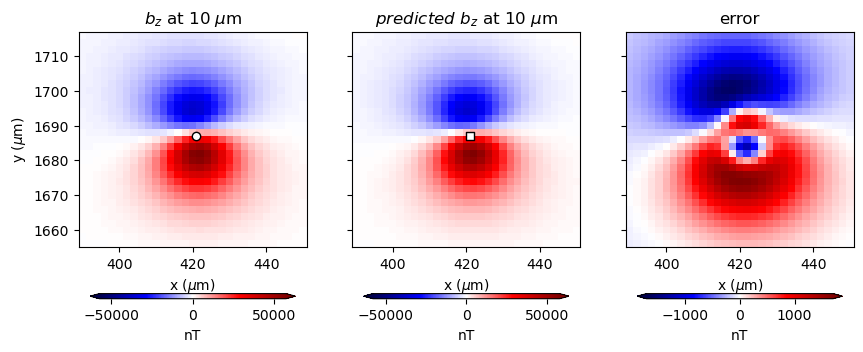

Individual source:   R2 = 0.9989074089505134 and SNR = 29.646061069864015


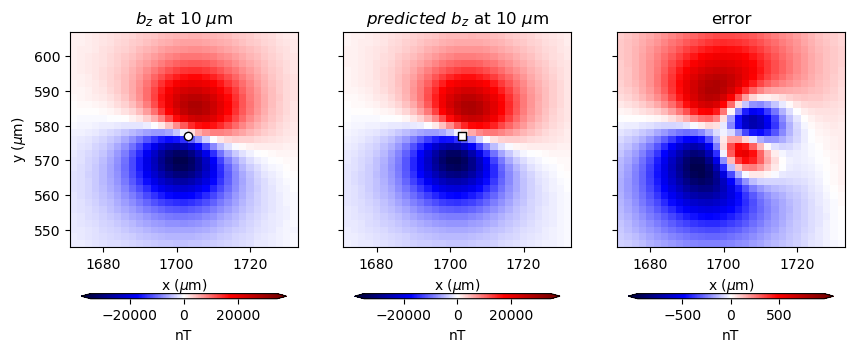

Individual source:   R2 = 0.9991804265485761 and SNR = 31.54634467990354


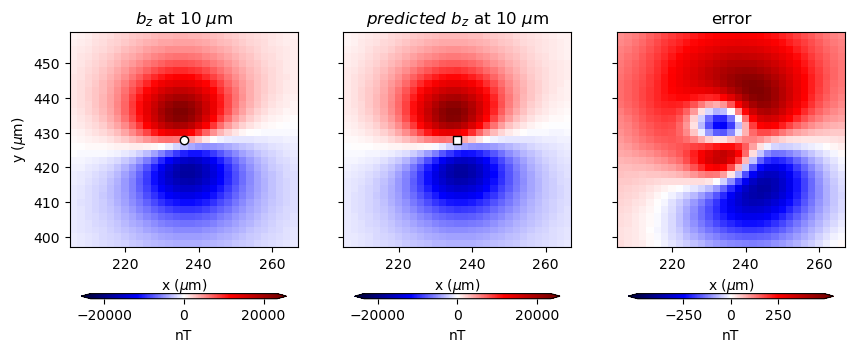

Individual source:   R2 = 0.9995516951909003 and SNR = 33.559547953949995


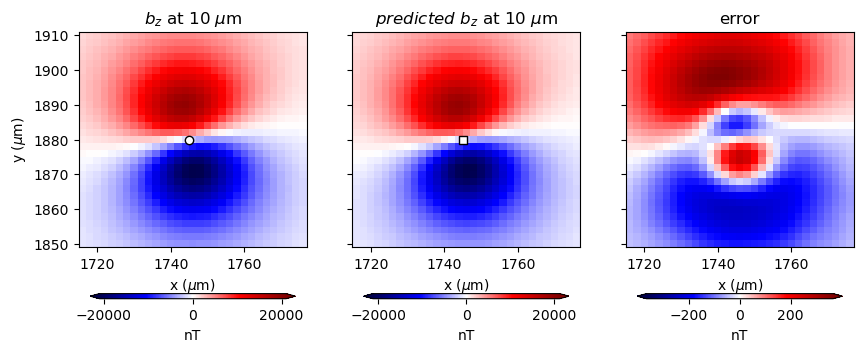

In [41]:
for window, r2, SNR in zip(windows[0:15], calculated_r2[0:15], calculated_SNR[0:15]):
    local_data = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    
    
    fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9)
    
    ax = axes[0]
    ax.set_aspect("auto")
    ax.set_title(f"$b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    ax.set_ylabel("y ($\mu$m)")
    tmp = local_data.bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    ax.scatter(dipole_coordinates[0], dipole_coordinates[1], color='w', marker='o', edgecolors='k')
    
    ax = axes[1]
    ax.set_aspect("auto")
    ax.set_title(f"$predicted~b_z$ at {sensor_sample_distance + height_difference:.0f} $\mu$m")
    ax.set_xlabel("x ($\mu$m)")
    tmp = local_data.predicted_data.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)#, vmax=vmax, vmin=vmin)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
    ax.scatter(positions[0], positions[1], color='w', marker='s', edgecolors='k')
    
    ax = axes[2]   
    ax.set_aspect("auto")
    ax.set_title("error")
    ax.set_xlabel("x ($\mu$m)")
    
    tmp = local_data.error.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
    fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs,  extend='both')
        
    # print r2 and SNR
    print(r"Individual source:   R2 = %s and SNR = %s"%(r2, SNR))

    plt.show()